In [237]:
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)
%matplotlib inline

In [181]:
PUF2014 = ['ME', 'AK', 'AR', 'DE', 'GA', 'IL', 'IN', 'KS', 'LA', 'MO', 'MI',
       'MT', 'NH', 'NM', 'OK', 'PA', 'SC', 'TN', 'TX', 'VA', 'WI', 'WV',
       'IA', 'ID', 'NE', 'OH', 'SD', 'UT']

PUF2015 = ['KS', 'LA', 'ME', 'MI', 'AK', 'AR', 'DE', 'GA', 'IL', 'IN', 'MO',
       'MT', 'NC', 'NH', 'NM', 'NV', 'OK', 'OR', 'PA', 'SC', 'TN', 'TX',
       'UT', 'VA', 'IA', 'WI', 'WV', 'NE', 'OH', 'SD']

PUF2016 = ['AK', 'AL', 'AR', 'DE', 'GA', 'IL', 'IN', 'KS', 'LA', 'ME', 'MI',
       'MO', 'MT', 'NC', 'NH', 'NM', 'NV', 'OK', 'PA', 'SC', 'TN', 'TX',
       'VA', 'HI', 'IA', 'WI', 'WV', 'NE', 'OH', 'OR', 'SD', 'UT']

PUF2017 = ['AL', 'AR', 'GA', 'IL', 'IN', 'KY', 'ME', 'MI', 'MO', 'MT', 'NH',
       'NM', 'NV', 'OK', 'SC', 'TX', 'VA', 'WI', 'DE', 'HI', 'IA', 'KS',
       'NE', 'OH', 'OR', 'PA', 'SD', 'UT', 'WV']


https://gist.github.com/wrobstory/5609889#file-choro-py

In [199]:
issuerCounts = pd.read_csv('issuerCounts.csv', dtype={'County': str})
issuerCounts.head()

,BusinessYear,StateCode,County,NumIssuers
0,2014,AK,02013,1
1,2014,AK,02016,1
2,2014,AK,02020,1
3,2014,AK,02050,1
4,2014,AK,02060,1


In [200]:
dtypes = {0:str,1:str,2:str, 3:str, 4:str}
colsToKeep = ['County', 'StateCode']
colNames = {0:'StateCode',1:'StateFP',2:'CountyFP', 3:'CountyName', 4:'ClassFP'}
fipsCodes = pd.read_csv('fips-codes.csv', header=None, dtype=dtypes).rename(columns=colNames)
fipsCodes['County'] = fipsCodes.StateFP.str.cat(fipsCodes.CountyFP)
fipsCodes = fipsCodes[colsToKeep]
fipsCodes.head()

,County,StateCode
0,01001,AL
1,01003,AL
2,01005,AL
3,01007,AL
4,01009,AL


In [212]:
def getAllCounties(df):
    return df.merge(fipsCodes, on=['StateCode','County'], how='outer')

def fillNas(df, PUF):
    df.loc[~df.StateCode.isin(PUF), 'NumIssuers'] = 0
    return df

def set_id(fips):
    '''Modify FIPS code to match GeoJSON property'''
    if fips == '0':
        return None
    elif len(fips) <= 4:
        return ''.join(['0500000US0', fips])
    else:
        return ''.join(['0500000US', fips])

def prepCountyDf(df, PUF):
    df = getAllCounties(df)
    df = fillNas(df,PUF)
    df['County'] = df.County.apply(set_id)
    return df

In [214]:
seventeen = prepCountyDf(seventeen, PUF2017)
seventeen['modNum'] = seventeen.NumIssuers.apply(lambda x: 2 if x > 1 else x)

In [219]:
countyGeo = r'us_counties_topo.json'

def makeCountyMap(df, dataCol):
    m = folium.Map(location=[43, -100], zoom_start=4)
    m.choropleth(
        geo_path=countyGeo,
        data=df,
        columns=['County',dataCol],
        key_on='feature.id',
        topojson='objects.us_counties_20m',
        fill_color='PuBuGn')
    return m

seventeenM = makeCountyMap(seventeen, 'modNum')
seventeenM

sixteen = prepCountyDf(issuerCounts[issuerCounts.BusinessYear == 2016], PUF2016)
sixteen['modNum'] = sixteen.NumIssuers.apply(lambda x: 2 if x > 1 else x)
sixteenM = makeCountyMap(sixteen, 'modNum')
sixteenM

fifteen = prepCountyDf(issuerCounts[issuerCounts.BusinessYear == 2015], PUF2015)
fifteen['modNum'] = sixteen.NumIssuers.apply(lambda x: 2 if x > 1 else x)
fifteenM = makeCountyMap(fifteen, 'modNum')
fifteenM

fourteen = prepCountyDf(issuerCounts[issuerCounts.BusinessYear == 2014], PUF2014)
fourteen['modNum'] = fourteen.NumIssuers.apply(lambda x: 2 if x > 1 else x)
fourteenM = makeCountyMap(fourteen, 'modNum')
fourteenM

In [230]:
issuerCounts.groupby('BusinessYear').NumIssuers.mean()

BusinessYear
2014    2.055024
2015    2.406803
2016    2.428698
2017    1.931883
Name: NumIssuers, dtype: float64

In [232]:
def getPercOne(g):
    return g[g.NumIssuers < 2].shape[0] / g.shape[0]
issuerCounts.groupby('BusinessYear').apply(getPercOne)

BusinessYear
2014    0.513876
2015    0.534240
2016    0.533215
2017    0.465941
dtype: float64

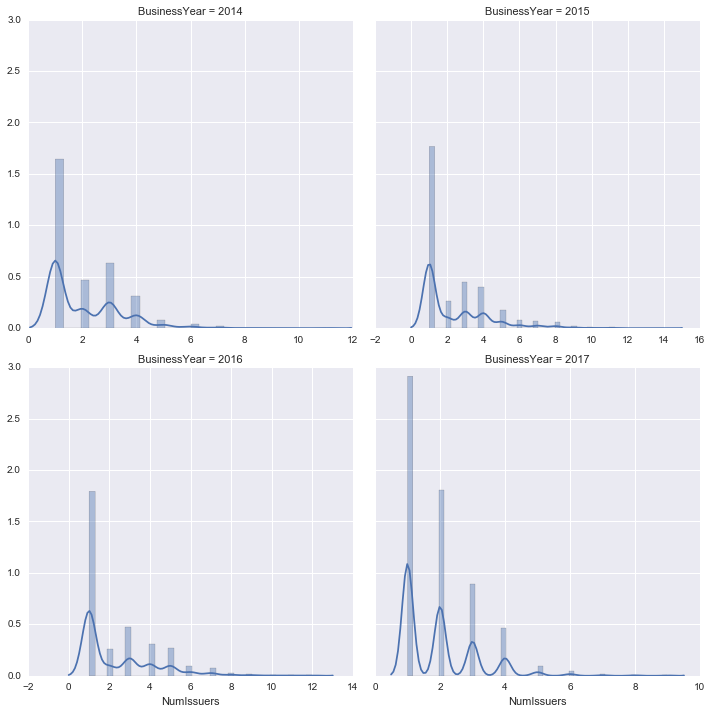

In [241]:
g = sns.FacetGrid(data=issuerCounts, col='BusinessYear', size=5, aspect=1, col_wrap=2, sharex=False)
g.map(sns.distplot, 'NumIssuers', norm_hist =True)

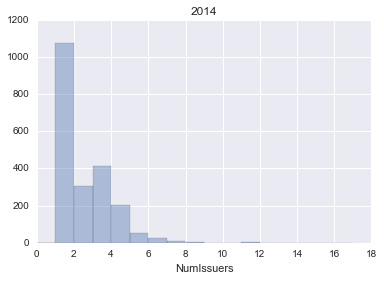

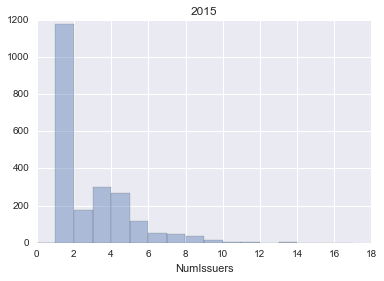

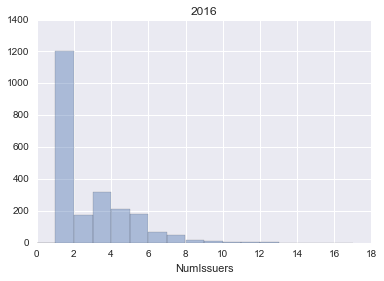

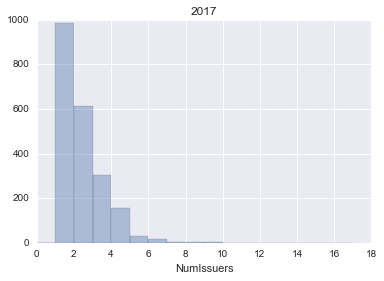

In [246]:
bins = range(0,18)
for year in [2014, 2015, 2016, 2017]:
    sns.distplot(issuerCounts[issuerCounts.BusinessYear == year].NumIssuers, kde=False, bins=bins)
    plt.title(year)
    plt.show()